<img alt='UCL' src="images/ucl_logo.png" align='center'>


[<img src="images/noun_post_2109127.svg" width="50" align='right'>](016_Python_for.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](018_Python_xxx.ipynb)



# 026 GDAL, and OGR masking

### Purpose


In this section, we'll look at combining both raster and vector data to provide a masked dataset ready to use. We will produce a combined dataset of leaf area index (LAI) over the UK derived from the MODIS sensor that we have examined before.


### Prerequisites

You will need some understanding of the following:


* [001 Using Notebooks](001_Notebook_use.ipynb)
* [010 Variables, comments and print()](010_Python_Introduction.ipynb)
* [011 Data types](011_Python_data_types.ipynb) 
* [012 String formatting](012_Python_strings.ipynb)
* [013_Python_string_methods](013_Python_string_methods.ipynb)
* [020_Python_files](020_Python_files.ipynb)
* [021 Streams](021_Streams.ipynb)
* [022 Read write files](022_Read_write_files.ipynb)
* [023 Plotting](023_Plotting.ipynb)
* [024 Image display](024_Image_display.ipynb)
* [025 NASA MODIS Earthdata](025_NASA_MODIS_Earthdata.ipynb)
* [026_Numpy](026_Numpy.ipynb)

### Test

You should run a [NASA account test](notebooks/004_Accounts.ipynb#Test) if you have not already done so.

## MODIS dataset access

You should by now be able to access MODIS data, either through specifying the URL of the file to download, or through using the `geog0111.modis` library as we have done in [024 Image display](024_Image_display.ipynb#MODIS)
 and [025 NASA MODIS Earthdata](025_NASA_MODIS_Earthdata.ipynb#MOTA).
 
 If we want to access only the local filename and/or SDS information for a particular, we can use the function:
 
     files,sds = modis.stitch_date(year,doy,get_files=True)
     
    

In [13]:
from geog0111.modis import Modis

kwargs = {
    'tile'      :    ['h17v03'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
}
doy = 41
year = 2019

modis = Modis(**kwargs)
# specify day of year (DOY) and year
# and get the filenames
files,sds = modis.stitch_date(year,doy,get_files=True)
# look at first dataset in lists
print(files[0])
print(sds[0])

/Users/plewis/Documents/GitHub/geog0111/notebooks/work/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h17v03.006.2019050221756.hdf.store
['HDF4_EOS:EOS_GRID:"/Users/plewis/Documents/GitHub/geog0111/notebooks/work/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h17v03.006.2019050221756.hdf.store":MOD_Grid_MCD15A3H:Lai_500m']


The SDS description (in `sds[0][0]` here) is rather long-winded, but contains the full pathname of the dataset, along with the specification for the `Lai_500m` sub-dataset.

Armed with the SDS description, we can read a dataset from the MODIS file using `g.ReadAsArray()` after we have opened it. It returns a numpy array.

In [34]:
import gdal
import numpy as np

this_sds = sds[0][0]
# open the SDS of dataset 0
g = gdal.Open(sds[0][0])
data = g.ReadAsArray()

print(type(data))
print('max:',data.max())
print('max:',data.min())
# get unique values, for interst
print('unique values:',np.unique(data))

<class 'numpy.ndarray'>
max: 255
max: 0
unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70 250
 253 254 255]


#### Exercise 1

Recall that the MODIS LAI data need a scaling factor of 0.1 applied, and that values of greater than 100 are invalid.


For the dataset described by:

    kwargs = {
        'tile'      :    ['h17v03'],
        'product'   :    'MCD15A3H',
        'sds'       :    'Lai_500m',
    }
    doy = 41
    year = 2019

* Use `gdal` to read the data into a `numpy` array called lai
* print the shape of the array `lai`
* Find the maximum valid LAI value in the dataset
* find at least one pixel (row, column) which has that maximum value.

You will need to recall how to filter and [mask `numpy` arrays](026_Numpy.ipynb#argmin,-argmax-and-masking) and use [`np.where`](026_Numpy.ipynb#where).

In [15]:
# ANSWER
# dont forget to import the packages you need
from geog0111.modis import Modis
import gdal
import numpy as np

# Use gdal to read the data into a numpy array called lai
kwargs = {
    'tile'      :    ['h17v03'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
}
doy = 41
year = 2019
modis = Modis(**kwargs)
files,sds = modis.stitch_date(year,doy,get_files=True)
g = gdal.Open(sds[0][0])
lai = g.ReadAsArray()
# print the shape of the array `lai`
print(f'shape of lai: {lai.shape}')

shape of lai: (2400, 2400)


In [28]:
# Find the maximum valid LAI value in the dataset
# first filter for valid
valid_mask = (lai <= 100)
# now apply, and scale
max_lai = lai[valid_mask].max()
print(f'max LAI is {max_lai * 0.1}')

# find pixels where it equals the max
where_max_mask = (lai == max_lai)

# find at least one pixel (row, column) 
# which has that maximum value.
row,col = np.where(where_max_mask)
print(row[0],col[0])

max LAI is 7.0
111 2199


## Tile stitching with `gdal.BuildVRT`

Each MODIS tile has (SDS) datasets that are typically 1200x1200 pixels (1 km resolution) or 2400x2400 pixels (500 m resolution). Whilst we have to consider the MODIS tiles when downloading a dataset, after that point, we will probably want to work with data over some area that may only be a portion of a tile, or that may involve multiple tiles.

One approach to this is to read the individual tile data as above, the sub-set or stitch together multiple tiles. This is perfectly possible using `numpy` (see [`np.vstack`](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) and [`np.hstack`](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) to follow that up), but not generally very convenient. 

Another factor is that, whilst the datasets are on regular grids, each location in the grid covers a unique geographical area. Once we load the data into a `numpy` array, we are no longer using the coordinate information available in the original geospatial dataset.

A final factor can be that it might be memory-inefficient to process data by reading it all into a large array.

Instead then, we can use `gdal` to stitch together geospatial data. A convenient way of doing this is to form a new `gdal` [virtual file](https://www.gdal.org/gdal_vrttut.html), using gdal.BuildVRT (check the documentation). 

This function takes two inputs: the output filename (`stitch_up.vrt`) and a set of GDAL format filenames. It returns the open output dataset, so that we can check what it looks like with e.g. `gdal.Info`.

We will use `modis.stitch_date` as above to provide the SDS of four MODIS tiles `['h17v03','h18v03','h17v04','h18v04']`

In [33]:
import gdal
from geog0111.modis import Modis

kwargs = {
    'tile'      :    ['h17v03','h18v03','h17v04','h18v04'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
}
doy = 41
year = 2019

modis = Modis(**kwargs)
files,sds = modis.stitch_date(year,doy,get_files=True)

# build a VRT 
stitch_vrt = gdal.BuildVRT("work/stitch_up.vrt", sds[0])

print(gdal.Info(stitch_vrt))

Driver: VRT/Virtual Raster
Files: work/stitch_up.vrt
Size is 4800, 4800
Coordinate System is:
PROJCRS["unnamed",
    BASEGEOGCRS["Unknown datum based upon the custom spheroid",
        DATUM["Not specified (based on custom spheroid)",
            ELLIPSOID["Custom spheroid",6371007.181,0,
                LENGTHUNIT["metre",1,
                    ID["EPSG",9001]]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]],
    CONVERSION["unnamed",
        METHOD["Sinusoidal"],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["False easting",0,
            LENGTHUNIT["Meter",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["Meter",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["easting",east,
            ORDER[1],
            LENGTHUNIT["Meter",1]],
        AXIS

So we see that we now have 4800 columns by 4800 rows dataset, centered around 0 degrees North, 0 degrees W. Let's plot the data...

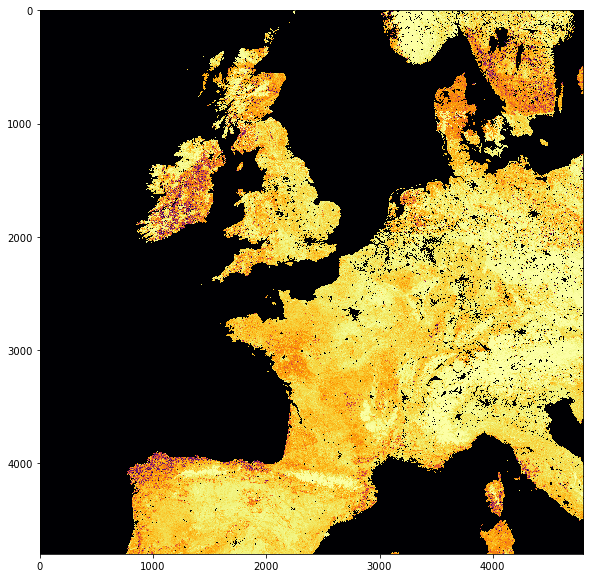

In [38]:
import matplotlib.pyplot as plt
# stitch_vrt is an already opened GDAL dataset, needs to be read in
plt.figure(figsize=(10,10))
plt.imshow(stitch_vrt.ReadAsArray()*0.1,
           interpolation="nearest", vmin=0, vmax=7, 
           cmap=plt.cm.inferno_r)

## Filtering by vector dataset with `gdal.Warp`

We can apply spatial filtering from a vector dataset, e.g. in a shape file, using [`gdal.Warp`](https://gdal.org/programs/gdalwarp.html). We will explore this by filtering MODIS LAI by country boundary data.

A number of vectors with countries and administrative subdivisions are available. The [TM_WORLD_BORDERS shapefile](http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip) is popular and in the public domain. You can see it, and have a look at the data [here](https://koordinates.com/layer/7354-tm-world-borders-03/). The security on the website means that we cannot directly download the file, so instead we use the version stored in the `data` directory [`data/TM_WORLD_BORDERS-0.3.zip`].

We will use the [FIPS code](https://en.wikipedia.org/wiki/FIPS_county_code) to refer to countries within the dataset and the `gdal` function `gdal.Warp` to filter by this vector dataset. The syntax is:

    g = gdal.Warp("", "stitch_up.vrt",
             format = 'MEM',
             cropToCutline = True,
             cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp', 
             cutlineWhere = "FIPS='UK'")


where:
* the first argument (`""` here) is the output filename
* the second argument (`"stitch_up.vrt"` here) is the input file
* `format = 'MEM'` means that the file is written to memory, rather than being stored in a file. 
* `cropToCutline = True` forces the dataset to be cropped at the dataset boundary
* `cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp'` specifies the vector boundary dataset
* `cutlineWhere = "FIPS='UK'"` provides the condition for sub-setting

If you want to save the resultant file, e.g. to geoTiff or VRT file, then you would use e.g.:

    g = gdal.Warp("uk.tif", "stitch_up.vrt",
             format = 'GTiff',
             cropToCutline = True,
             cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp', 
             cutlineWhere = "FIPS='UK'")

or

    g = gdal.Warp("uk.vrt", "stitch_up.vrt",
             format = 'VRT',
             cropToCutline = True,
             cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp', 
             cutlineWhere = "FIPS='UK'")


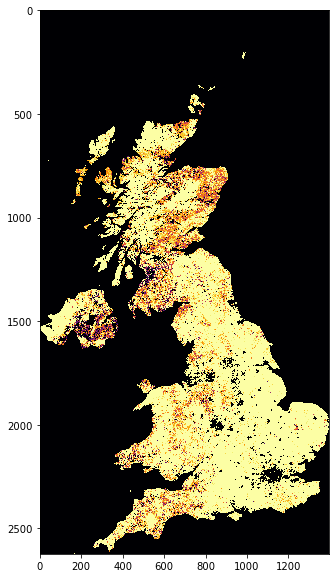

In [67]:
import gdal
from geog0111.modis import Modis

kwargs = {
    'tile'      :    ['h17v03','h18v03','h17v04','h18v04'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
}
doy = 41
year = 2019

modis = Modis(**kwargs)
files,sds = modis.stitch_date(year,doy,get_files=True)

# build a VRT 
stitch_vrt = gdal.BuildVRT("work/stitch_up.vrt", sds[0])

g = gdal.Warp("", "work/stitch_up.vrt",
        format = 'MEM',cropToCutline = True,
        cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp', 
        cutlineWhere = "FIPS='UK'")

# read and plot data
masked_lai = g.ReadAsArray()*0.1
plt.figure(figsize=(10,10))
plt.imshow(masked_lai, interpolation="nearest", vmin=1, vmax=3, 
          cmap=plt.cm.inferno_r)

####  Exercise 1

* Download data for these same four tiles from the **MODIS snow cover** dataset for some particular date (in winter). Check the related quicklooks to see that the dataset isn't all covered in cloud.
* show the snow cover for one or more selected countries.
* calculate summary statistics for the datasets.

**Hint** the codes would be very similar to above, but watch out for the scaling factor not being the same (no scaling for the snow cover!). Also, watch out for the dataset being on a different NASA server to the LAI data (as in exercise above).

When you calculate summary statistics, make sure you ignore all invalid pixels. You could do that by generating a mask of the dataset (after you have clipped it) using `np.where()`, and only process those pixels, e.g.:

    image[np.where(image<=100)].mean()
    
rather than

    image.mean()
    
as the latter would include invalid pixels.

In [28]:
# do exercise here